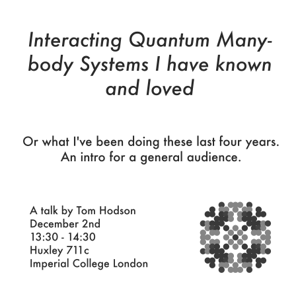

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from time import time
original_image = Image.open("../event_card_3.png")

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

original_image = expand2square(original_image, (255,255,255))

im = original_image.convert("L").resize((300, 300))
im

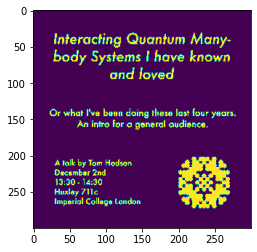

In [3]:
src = np.array(im) < 200
plt.imshow(src)

CPU times: user 7.01 s, sys: 5.16 s, total: 12.2 s
Wall time: 12.8 s


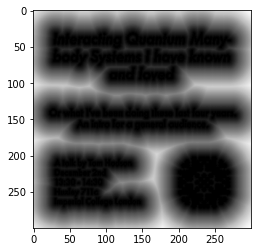

In [4]:
%%time
pixels = np.array(np.where(src))[:, :]

I = np.arange(src.shape[0]).reshape(-1,1,1)
J = np.arange(src.shape[1]).reshape(1,-1,1)

groups = 50

def compute(k):
    i, j = pixels[:, k::groups].reshape(2, 1, 1, -1)
    dist = np.min(np.sqrt((I - i)**2 + (J - j)**2), axis = -1, initial = 1000)
    return dist

dist = np.min([compute(k) for k in range(groups)], axis = 0)

d =  1 - dist / np.max(dist)
plt.imshow(d, cmap = 'Greys')

(5000, 2)


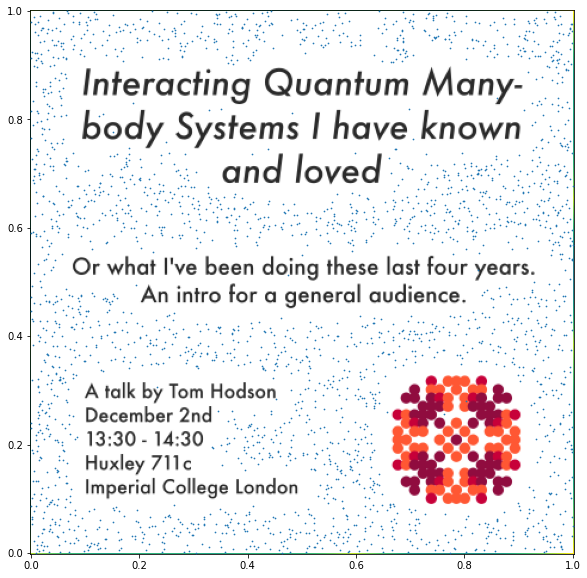

In [7]:
rng = np.random.default_rng(2264263456734)
points = rng.random((5000, 2))
print(points.shape)

x, y = np.linspace(0,1,dist.shape[0]), np.linspace(0,1,dist.shape[1])

f, ax = plt.subplots(figsize = (10,10))
ax.pcolor(x, y, dist[::-1, ::1], zorder = -1)

import scipy.interpolate
value_at_points  = scipy.interpolate.interpn([x,y], d[::-1, :].T, points)
r = rng.random(points.shape[0])

a = 30 #hard the falloff with distance is, larger means harder edge
b = 0.8 #density between 0 and 1
def l(x): return a*(x - b)
def s(x): return  np.exp(x) / (1 +  np.exp(x))
mask = s(l(value_at_points)) < r

# mask = value_at_points < 0.9
ax.imshow(original_image, extent = (0,1,0,1))
points = points[mask]
# points = np.concatenate([points, [[0.5, 0.07],]])

ax.scatter(*points.T, zorder = 10, s = 0.5)

# ax.scatter(0.5, 0.07)

In [8]:
from koala import voronization, graph_color, flux_finder
from koala import example_graphs as eg
from matplotlib import pyplot as plt
from koala import plotting as pl
import numpy as np

In [9]:
print(f"Generating lattice")
t0 = time()
lattice = voronization.generate_lattice(points)
print(f"Done in {(time() - t0):.0f} s")

Generating lattice
Done in 11 s


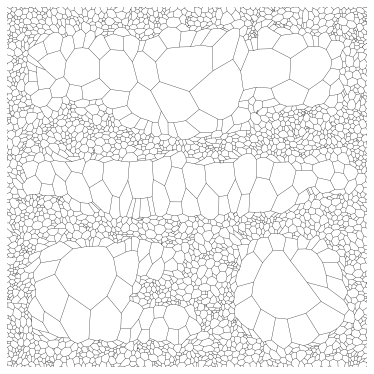

In [12]:
w,h = (5, 5)
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)


# ax.imshow(original_image, extent = (0,1,0,1))
pl.plot_edges(lattice, linewidth = 0.3)
fig.savefig("event_card.svg")

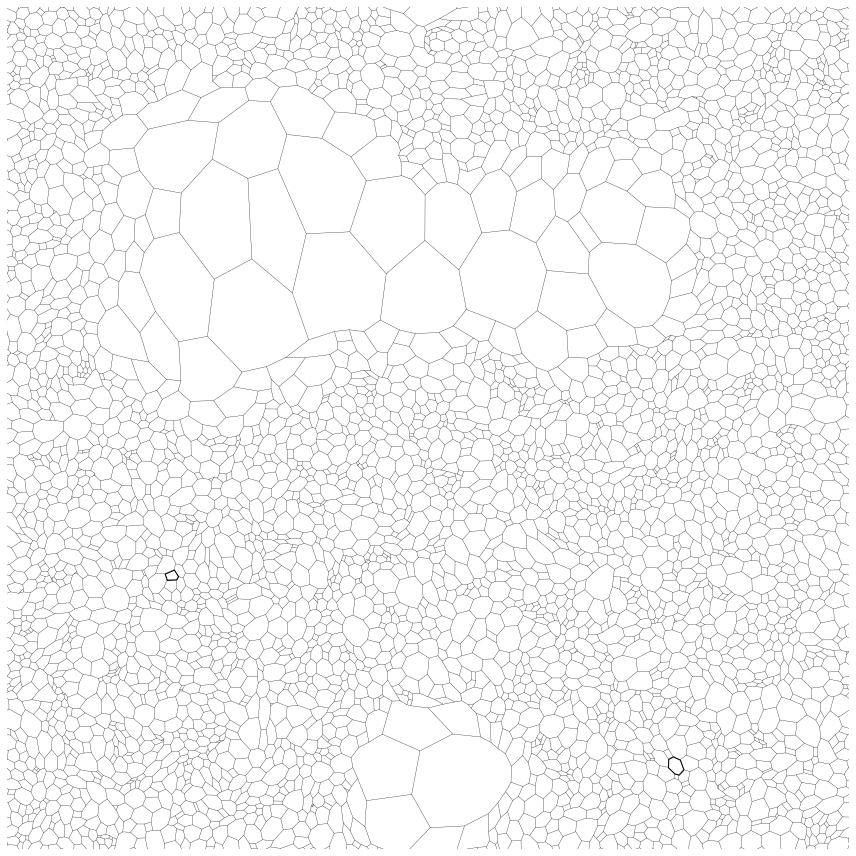

In [8]:
from koala import graph_utils as gu
from koala.flux_finder import pathfinding

gs_flux_sector = np.array([eg.ground_state_ansatz(p.n_sides) for p in lattice.plaquettes], dtype=np.int8)
ujk = flux_finder.find_flux_sector(lattice, gs_flux_sector)

a, b = gu.closest_plaquette(lattice, [0.2, 0.32]), gu.closest_plaquette(lattice, [0.8, 0.1])
plaq_path, edge_path = pathfinding.path_between_plaquettes(lattice, a, b)
ujk[edge_path] *= -1 
flux_sector = flux_finder.fluxes_from_bonds(lattice, ujk)


w,h = (11.6929, 11.6929)
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)


# ax.imshow(original_image, extent = (0,1,0,1))
pl.plot_edges(lattice, linewidth = 0.3)
# fig.savefig("amk_chapter_background_2.svg")

pl.plot_plaquettes(lattice, subset = np.array(plaq_path)[[0, -1 ]], linewidth = 1, ax = ax, color_scheme = ["white",], zorder = 1, ec = 'k')
# pl.plot_dual(lattice, subset = edge_path, linewidth = 1, ax = ax,
#              color_scheme = ["red",], zorder = 1)



In [9]:
from koala import voronization, graph_color
import matplotlib
coloring = graph_color.color_lattice(lattice)
line_colors = [matplotlib.colors.to_hex(a) for a in matplotlib.cm.inferno([0.25, 0.5, 0.75])]

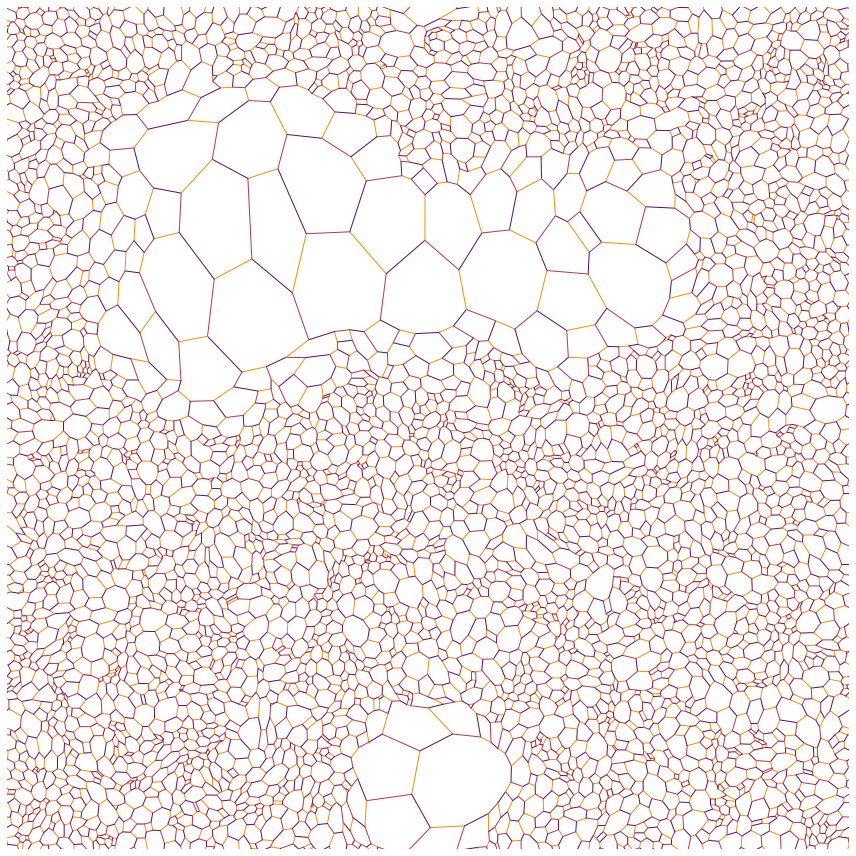

In [10]:
w,h = (11.6929, 11.6929)
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# ax.imshow(original_image, extent = (0,1,0,1))
pl.plot_edges(lattice, linewidth = 1, labels = coloring, color_scheme = line_colors)
fig.savefig("amk_chapter_background_colour_2.svg")

In [11]:
from koala import hamiltonian
# J = np.array([1,1,1])

# print(f"Diagonalising lattice of {lattice.n_plaquettes} plaqs")
# t0 = time()
# H = hamiltonian.generate_majorana_hamiltonian(lattice, coloring, ujk, J)
# eigs, vecs = np.linalg.eigh(H)

# idx = np.argsort(np.abs(eigs))
# lowest_wavefunction = vecs[:, idx[0]]
# print(f"Done in {(time() - t0)/60:.0f} min")

In [13]:
import scipy.sparse.linalg
print(f"Diagonalising lattice of {lattice.n_plaquettes} plaqs using sparse matrices")
t0 = time()
J = np.ones(3)
H = hamiltonian.generate_majorana_hamiltonian(lattice, coloring, ujk, J)
eigs, vecs = scipy.sparse.linalg.eigs(H, k=1, sigma=0)
print(f"Done in {(time() - t0):.0f} s")

Diagonalising lattice of 3822 plaqs using sparse matrices
Done in 10 s


In [14]:
edge_state_i = np.argsort(np.abs(eigs))[0]

edge_state = vecs[:, edge_state_i]
edge_state_energy = eigs[edge_state_i]
edge_state_density = np.abs(edge_state)

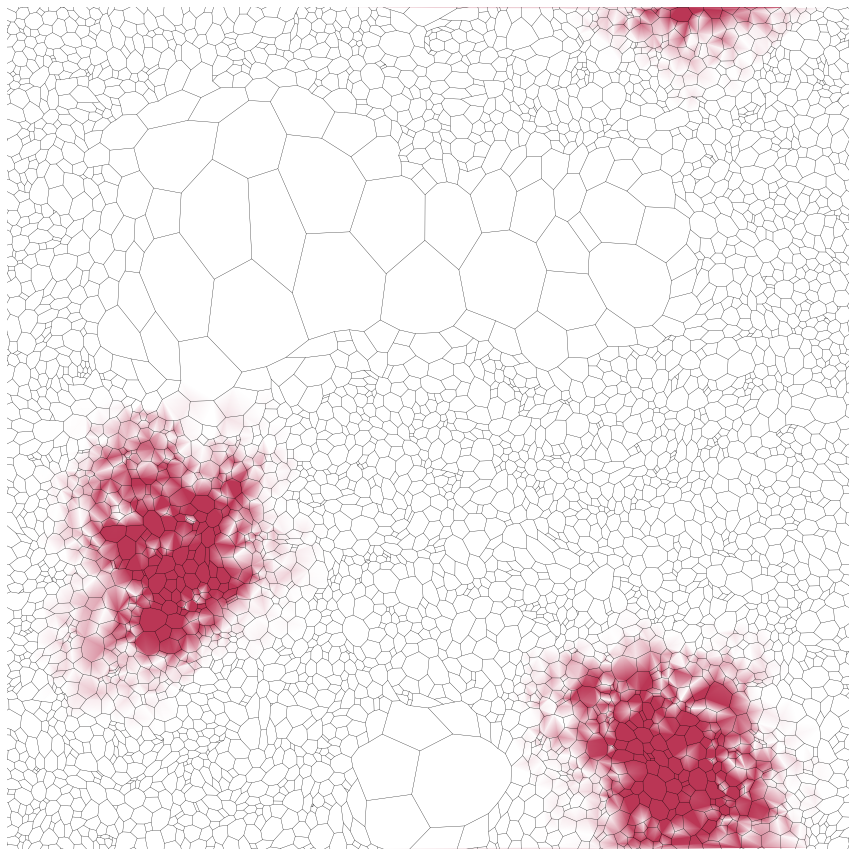

In [18]:
w,h = (11.6929, 11.6929)
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

## Setup colormap
from matplotlib.colors import ListedColormap
inferno = matplotlib.cm.get_cmap('inferno_r', 256)
newcolors = inferno(np.linspace(0.7, 0, 256))
white = np.array([1, 1, 1, 1])
newcolors[-1, :] = white
inferno_purple_to_white_cmap = ListedColormap(newcolors)

purple = inferno(0.5)
white = np.array([1,1,1,1])
t = np.linspace(0, 1, 256)[:, None]
newcolors = t * purple + (1-t) * white
plum_to_white_cmap = ListedColormap(newcolors)

ax.tripcolor(*lattice.vertices.positions.T, 
             edge_state_density,
             cmap = plum_to_white_cmap,
             shading = 'gouraud', vmin = 0.001, vmax = 0.01, zorder = -2,
             alpha = 1,
            )

pl.plot_edges(lattice, linewidth = 0.3, zorder = 1)
# pl.plot_plaquettes(lattice, subset = np.array(plaq_path)[[0, -1 ]], linewidth = 1, ax = ax, color_scheme = [None,], zorder = 1, ec = 'k', facecolor = (0,0,0,0))
#
# pl.plot_plaquettes(lattice, subset = np.array(plaq_path)[[0, -1 ]], linewidth = 1, ax = ax, color_scheme = [None,], zorder = 1, ec = (0,0,0,0), facecolor = (0,0,0,0.5))

# pl.plot_dual(lattice, subset = edge_path, linewidth = 1, ax = ax, color_scheme = ["k",], zorder = 1)
# positions = np.array([lattice.plaquettes[i].center for i in np.array(plaq_path)[[0, -1 ]]])
# ax.plot(*positions.T, "k")
ax.set_rasterization_zorder(0)
fig.savefig("amk_chapter_background_majorana.svg")

In [ ]:
import pickle
data = dict(
    points = points,
    lattice = lattice,
    coloring = coloring,
    ujk = ujk,
    J = J,

    edge_state_i = edge_state_i,
    edge_state = edge_state,
    edge_state_density = edge_state_density,
)

with open(f"chapter_4_cover_data.pickle", "wb") as f:
    pickle.dump(data, f)